In [2]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [12]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)
X = X.to_numpy()

(70000, 784)
(70000,)


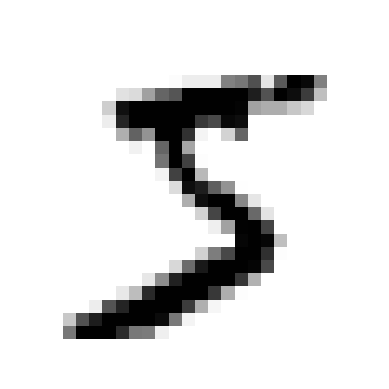

In [18]:
#display image

import matplotlib as mpl
import matplotlib.pyplot as plt


some_digit = X[0]

def show_image(x):
    some_digit_image = x.reshape(28 , 28)
    plt.imshow(some_digit_image , cmap= mpl.cm.binary , interpolation="nearest")
    plt.axis("off")
    plt.show()

show_image(some_digit)

In [ ]:
y = y.astype(np.uint8) # sting to int convertion


In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


In [ ]:
#step one : test to find just the number 5

y_train_5 = (y_train == 5)
y_test_5  = (y_test  == 5)

#SGDClassifire
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train , y_train_5)

sgd_clf.predict([X[0]])

array([ True])

In [ ]:
#Implementing Cross-Validation

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3 , random_state=42 , shuffle=True)

for train_index , test_index in skfolds.split(X_train , y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds  = X_train[test_index]  
    y_tset_folds  = y_train_5[test_index]

    clone_clf.fit(X_train_folds , y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_tset_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [ ]:
#use cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf , X_train , y_train_5 , cv = 3 , scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
#a model has trainded to find class not-5

from sklearn.base import BaseEstimator

class Never5Classifire(BaseEstimator):
    def fit(self , X , y = None):
        pass
    def predict(self , X):
        return np.zeros((len(X) , 1 ) ,dtype=bool)
never_5_clf = Never5Classifire()
cross_val_score(never_5_clf , X_train , y_train_5 , cv = 3 , scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

In [ ]:
#That’s right, it has over 90% accuracy! This is simply because only about 10% of the
#images are 5s, so if you always guess that an image is not a 5, you will be right about
#90% of the situation

In [ ]:
#Confusion Matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf , X_train , y_train_5 , cv = 3)

real_confusion = confusion_matrix(y_train_5 , y_train_pred)
real_confusion

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_prefect_predictions = y_train_5
confusion = confusion_matrix(y_train_5 , y_train_prefect_predictions)
confusion

array([[54579,     0],
       [    0,  5421]])

In [ ]:
#precision of the classifier 
precision = confusion[0][0] / (confusion[0][0] + confusion[1][1])
print("precision : " , precision)

precision :  0.90965


In [ ]:
#several functions to compute classifier metrics
from sklearn.metrics import precision_score , recall_score
print("precision_score : " , precision_score(y_train_5 , y_train_pred) )
print("recall_score : " , recall_score(y_train_5 , y_train_pred))

precision_score :  0.8370879772350012
recall_score :  0.6511713705958311


In [ ]:
#F1 score
from sklearn.metrics import f1_score
f1_score(y_train_5 , y_train_pred)

0.7325171197343847

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_sime_digit_pred = (y_scores > threshold)
print(y_sime_digit_pred)

[2164.22030239]
[ True]


In [ ]:
#resise the threshold
threshold = 8000
y_sime_digit_pred = (y_scores > threshold)
y_sime_digit_pred

array([False])

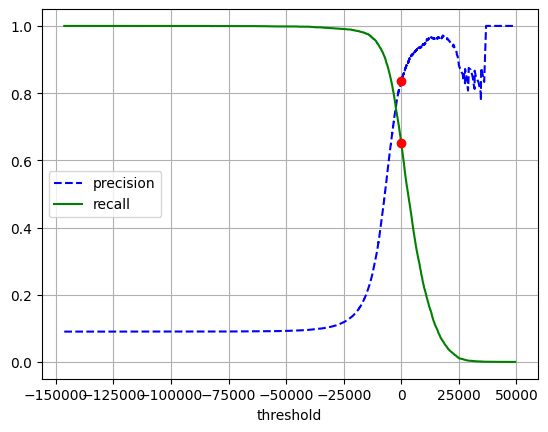

In [ ]:
#how to find threshold
y_scores = cross_val_predict(sgd_clf , X_train , y_train_5 , cv = 3 , method="decision_function")

from sklearn.metrics import precision_recall_curve
precision , recalls , threshold = precision_recall_curve(y_train_5 , y_scores)
close_zero_index = np.argmin(np.abs(threshold))


#precision and recall as functions of the threshold value
def plot_precision_reacall_vs_treshold(precisions , recalls , threshold):
    plt.plot(threshold , precision[:-1] , "b--" , label = "precision")
    plt.plot(threshold , recalls[:-1] , 'g-' , label = "recall")
    plt.plot(threshold[close_zero_index] , precision[close_zero_index] , 'ro')
    plt.plot(threshold[close_zero_index] , recalls[close_zero_index] , 'ro')
    plt.xlabel("threshold")
    plt.legend(loc = "center left")
    plt.grid(True)

plot_precision_reacall_vs_treshold(precision , recalls , threshold)
plt.show()


In [ ]:
threshold_90_precision = threshold[np.argmax(precision >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5 , y_train_pred_90))
print(recall_score(y_train_5,y_train_pred_90))

0.9000345901072293
0.4799852425751706


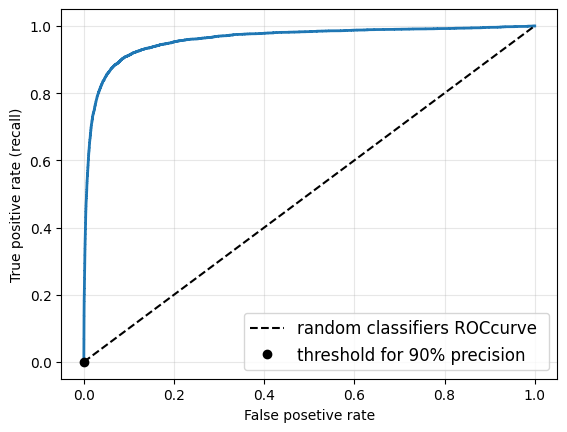

In [ ]:
#ROC curve

from sklearn.metrics import roc_curve
fpr , tpr , thresholds = roc_curve(y_train_5 , y_scores)
idx_for_threshold_at_90 = np.argmax((threshold <= threshold_90_precision))
tpr_90 , fpr_90 = tpr[idx_for_threshold_at_90] , fpr[idx_for_threshold_at_90]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr , linewidth = 2 , label = label)
    plt.plot([0,1] , [0,1] , 'k--' , label = 'random classifiers ROCcurve ')
    plt.plot([fpr_90] , [tpr_90] , 'ko' , label = 'threshold for 90% precision')
    plt.xlabel("False posetive rate")
    plt.ylabel("True positive rate (recall)")
    plt.grid(True , alpha = 0.3)
    plt.legend(loc = 'lower right' , fontsize = 12)
plot_roc_curve(fpr , tpr )
plt.show()
#The dotted line represents the ROC curve of a purely
#random classifier; a good classifier stays as far away from that line as possible

In [ ]:
#compute the ROC AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5 , y_scores)

np.float64(0.9604938554008616)

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf , X_train , y_train_5 , cv = 3 , method="predict_proba")

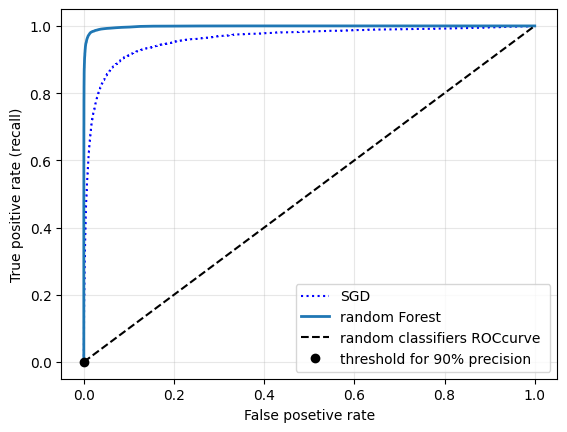

In [ ]:
y_scores_forest = y_probas_forest[: , -1]
fpr_forest , tpr_forest , threshold_forest = roc_curve(y_train_5 , y_scores_forest)
plt.plot(fpr , tpr , 'b:' , label = 'SGD')
plot_roc_curve(fpr_forest , tpr_forest ,"random Forest")
plt.legend(loc = "lower right")
plt.show()


In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [ ]:
sgd_clf.fit(X_train , y_train)


SGDClassifier(random_state=42)

In [ ]:
#sklearn automatic use OVA real time strategy
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
sgd_clf.classes_
#you can see classes of target

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
#classifier using OVO
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train , y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5]
45


In [ ]:
#random forest
forest_clf.fit(X_train , y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
#to see probability of each digit
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [ ]:
#accuracy using cross val score
cross_val_score(sgd_clf , X_train , y_train , cv = 3 , scoring="accuracy")


array([0.87365, 0.85835, 0.8689 ])

In [ ]:
cross_val_score(ovo_clf , X_train , y_train , cv = 3 , scoring="accuracy")


array([0.91545, 0.9131 , 0.92045])

In [ ]:
cross_val_score(forest_clf , X_train , y_train , cv = 3)

array([0.9646 , 0.96255, 0.9666 ])

In [ ]:
#simply scaling the inputs 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf , X_train , y_train , cv= 3 , scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
#you have found a promising model and you want to find ways to improve it.
#one way is to analyze the types of errors it makes
y_train_pred = cross_val_predict(sgd_clf , X_train_scaler , y_train , cv = 3)
conf_mx = confusion_matrix(y_train , y_train_pred)
conf_mx


array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

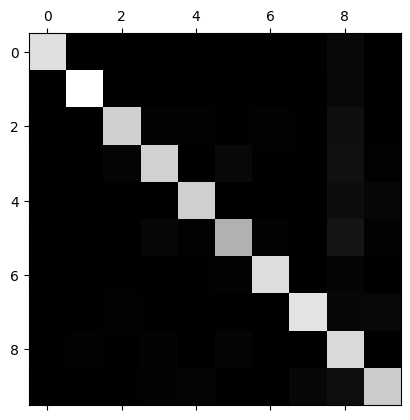

In [ ]:
plt.matshow(conf_mx , cmap = plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis = 1 , keepdims=True)
norm_conf_mx = conf_mx / row_sums


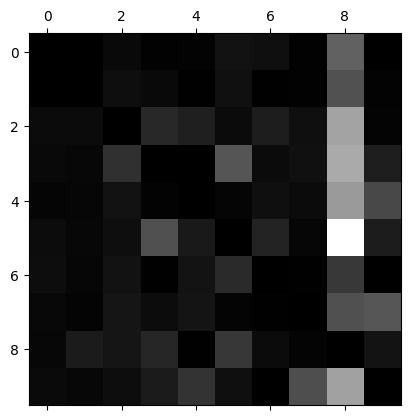

In [ ]:
np.fill_diagonal(norm_conf_mx , 0)
plt.matshow(norm_conf_mx , cmap = plt.cm.gray)
plt.show()

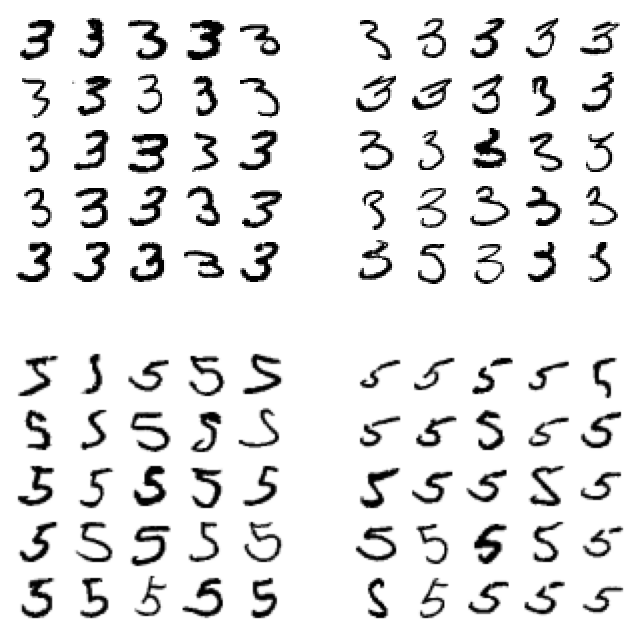

In [ ]:
def plot_digits(instance , image_per_row=10):
    size = 28
    image_per_row = min(len(instance) , image_per_row)
    n_rows = (len(instance) - 1) // image_per_row + 1
    n_empty = n_rows * image_per_row - len(instance)
    padded = np.concatenate([instance , np.zeros((n_empty , size * size))] , axis=0)
    image_grid = padded.reshape((n_rows , image_per_row , size , size))
    big_image = image_grid.swapaxes(1,2).reshape((n_rows * size , image_per_row * size))
    plt.imshow(big_image , cmap="binary")
    plt.axis("off")



cl_a , cl_b = 3 , 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], image_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], image_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], image_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], image_per_row=5)
plt.show()

In [ ]:
#Multiclass classification with several outputs
from sklearn.neighbors import KNeighborsClassifier
y_train_larg = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_larg , y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train , y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
#calculate F1
y_train_knn_pred = cross_val_predict(knn_clf ,X_train , y_multilabel , cv = 3)
f1_score(y_multilabel , y_train_knn_pred , average="macro")


0.9764102655606048

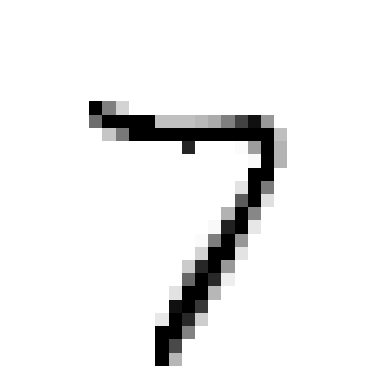

In [ ]:
#It will take an input as a noisy digit image, and it will output a clean digit image
noise = np.random.randint(0,100,(len(X_train) , 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test) , 784))
X_test_mod = X_test + noise
Y_train_mod = X_train
y_test_mod = X_test

#train
knn_clf.fit(X_train_mod , Y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digits(clean_digit)